## Load the data
The dataset is loaded and the target variable along with input features are defined.

In [1]:
import pandas as pd
# Load the data
df = pd.read_csv('./life-expectancy.csv')

# Basic statistics
print(df.describe())

              Year  Life expectancy  Unemployment  Infant Mortality  \
count  9928.000000      9928.000000   9928.000000       9928.000000   
mean   2009.495367        69.833645      8.256285         30.234766   
std       5.761572         9.301549      6.155461         25.460810   
min    2000.000000        38.861000      0.052000          1.400000   
25%    2005.000000        63.894250      4.331000          9.300000   
50%    2009.000000        71.445000      6.561500         23.300000   
75%    2014.000000        76.845250     10.132750         44.865050   
max    2019.000000        88.100000     43.166000        146.200000   

                GDP           GNI  Clean fuels and cooking technologies  \
count  9.928000e+03  9.928000e+03                           9928.000000   
mean   2.032870e+12  2.042054e+12                             60.593023   
std    7.249370e+12  7.254721e+12                             36.963992   
min    6.310127e+07  7.280219e+07                           

In [2]:
# Define the target variable and input features
target = 'Life expectancy'
inputs = [c for c in df.columns if c != target]

## Select Numerical Features
Only numerical features are selected for predictors.

In [3]:
X = df[inputs].select_dtypes([int, float])
y = df[target]

## Correlation Matrix
Calculate and visualize the correlation matrix using a heatmap.

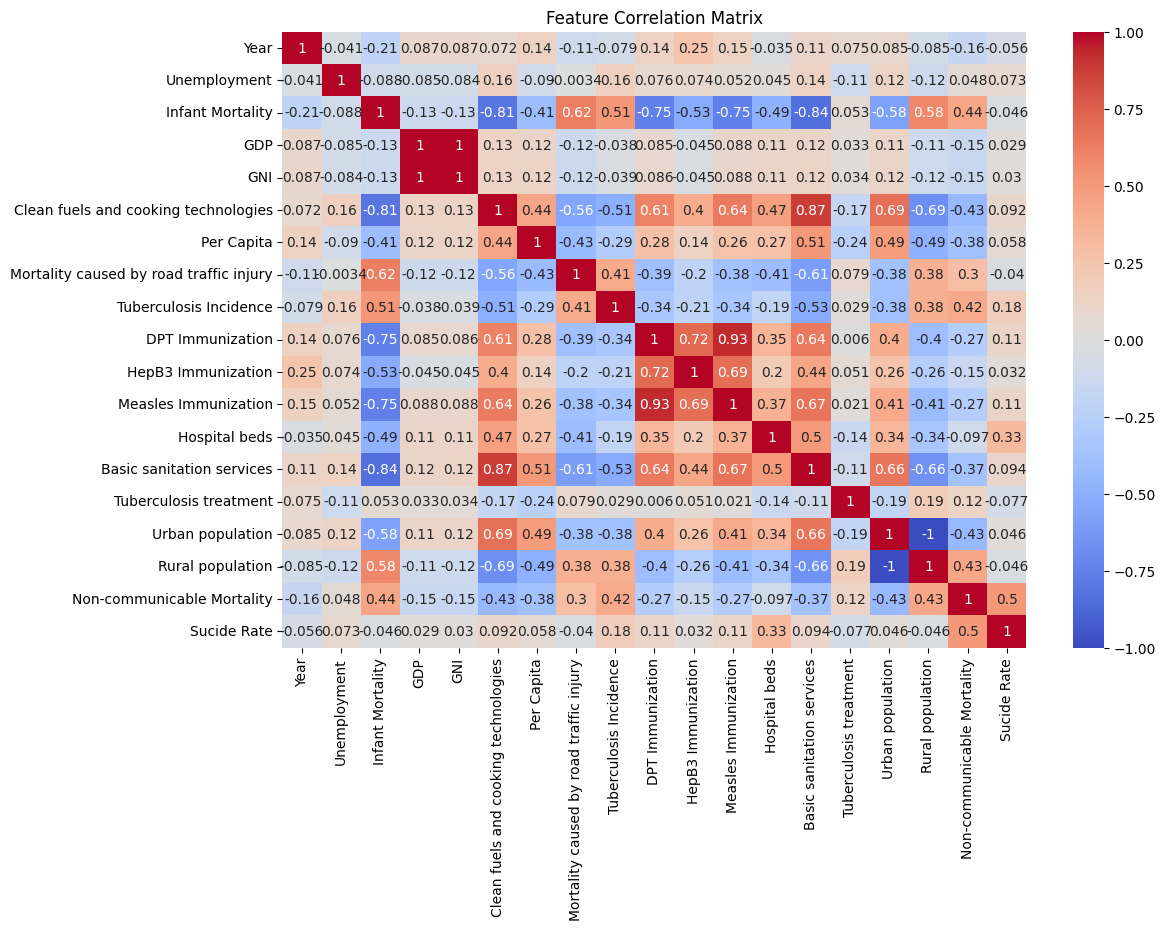

In [4]:
# Visualize the correlation matrix using a heatmap
from matplotlib import pyplot as plt
import seaborn as sns

correlation_matrix = X.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

## Identify Highly Correlated Features
Features with a correlation coefficient greater than 0.8 (or less than -0.8) are considered highly correlated and one of each pair is removed.

In [5]:
highly_correlated_pairs = [(feature1, feature2, correlation_matrix.loc[feature1, feature2])
                           for feature1 in correlation_matrix.columns
                           for feature2 in correlation_matrix.columns
                           if feature1 != feature2 and abs(correlation_matrix.loc[feature1, feature2]) >= 0.8]

# Print highly correlated feature pairs
print("Highly correlated feature pairs (correlation > 0.8 or < -0.8):")
for feature1, feature2, corr_value in highly_correlated_pairs:
    print(f"{feature1} and {feature2}: {corr_value:.2f}")

# Remove one feature from each pair of highly correlated features
features_to_remove = set()
for feature1, feature2, _ in highly_correlated_pairs:
    features_to_remove.add(feature2)

print(f"Removing the following features due to high correlation: {features_to_remove}")
X_deduped = X.drop(columns=features_to_remove)

Highly correlated feature pairs (correlation > 0.8 or < -0.8):
Infant Mortality and Clean fuels and cooking technologies: -0.81
Infant Mortality and Basic sanitation services: -0.84
GDP and GNI: 1.00
GNI and GDP: 1.00
Clean fuels and cooking technologies and Infant Mortality: -0.81
Clean fuels and cooking technologies and Basic sanitation services: 0.87
DPT Immunization and Measles Immunization: 0.93
Measles Immunization and DPT Immunization: 0.93
Basic sanitation services and Infant Mortality: -0.84
Basic sanitation services and Clean fuels and cooking technologies: 0.87
Urban population and Rural population: -1.00
Rural population and Urban population: -1.00
Removing the following features due to high correlation: {'Measles Immunization', 'Basic sanitation services', 'DPT Immunization', 'Clean fuels and cooking technologies', 'GDP', 'Rural population', 'Infant Mortality', 'GNI', 'Urban population'}


# Identify numerical and categorical features

In [6]:
import numpy as np

numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

Numerical Features: ['Year', 'Unemployment', 'Infant Mortality', 'GDP', 'GNI', 'Clean fuels and cooking technologies', 'Per Capita', 'Mortality caused by road traffic injury', 'Tuberculosis Incidence', 'DPT Immunization', 'HepB3 Immunization', 'Measles Immunization', 'Hospital beds', 'Basic sanitation services', 'Tuberculosis treatment', 'Urban population', 'Rural population', 'Non-communicable Mortality', 'Sucide Rate']
Categorical Features: ['Country', 'Gender']


## Data Preprocessing
A function to preprocess the data by filling missing values and standardizing the numerical features.

In [7]:
from sklearn.discriminant_analysis import StandardScaler


def preprocess_data(X, y):
    # Handle missing values
    for column in X.columns:
        if X[column].dtype == 'float64':
            X[column] = X[column].fillna(X[column].mean())
        elif X[column].dtype == 'object':
            X = X[X[column].notnull()]
            
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X, y, X_scaled

## Evaluate Linear Regression Model
A function to train and evaluate a Linear Regression model.

In [8]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def evaluate_linear_model(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    return r2_train, r2_test, model

## Evaluate Scaled Linear Regression Model
A function to train and evaluate a Linear Regression model with standardized data.

In [9]:
def evaluate_linear_model_scaled(X_train_scaled, X_test_scaled, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    return r2_train, r2_test, model

## Evaluate ElasticNet Model
A function to train and evaluate an ElasticNet model, finding the best regularization parameters using ElasticNetCV.

In [10]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

def evaluate_elastic_net(X_train_scaled, X_test_scaled, y_train, y_test, random_state):
    elastic_net_cv = ElasticNetCV(cv=5, random_state=random_state)
    elastic_net_cv.fit(X_train_scaled, y_train)
    best_alpha = elastic_net_cv.alpha_
    best_l1_ratio = elastic_net_cv.l1_ratio_
    model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    return r2_train, r2_test, model

## Evaluate Polynomial ElasticNet Model
A function to train and evaluate a Polynomial ElasticNet model, finding the best regularization parameters using ElasticNetCV.

In [11]:
from sklearn.model_selection import train_test_split

def evaluate_polynomial_elastic_net(X_poly, y, random_state):
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=random_state)
    elastic_net_cv = ElasticNetCV(cv=5, random_state=random_state)
    elastic_net_cv.fit(X_train_poly, y_train_poly)
    best_alpha = elastic_net_cv.alpha_
    best_l1_ratio = elastic_net_cv.l1_ratio_
    model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
    model.fit(X_train_poly, y_train_poly)
    y_pred_train_poly = model.predict(X_train_poly)
    y_pred_test_poly = model.predict(X_test_poly)
    r2_train = r2_score(y_train_poly, y_pred_train_poly)
    r2_test = r2_score(y_test_poly, y_pred_test_poly)
    return r2_train, r2_test, model

## Run Multiple Evaluations
A function to run multiple evaluations (with different train-test splits) for each model type and collect results.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

def run_evaluations(X, y, num_repeats):
    X, y, X_scaled = preprocess_data(X, y)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X_scaled)
    results = {
        'Linear Regression': [],
        'Linear Regression (Scaled)': [],
        'ElasticNet': [],
        'Polynomial ElasticNet': []
    }
    models = {
        'Linear Regression': [],
        'Linear Regression (Scaled)': [],
        'ElasticNet': [],
        'Polynomial ElasticNet': []
    }
    for i in range(num_repeats):
        # Split data differently each time
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=i)
        
        # Evaluate Linear Regression
        r2_train, r2_test, model_lr = evaluate_linear_model(X_train, X_test, y_train, y_test)
        results['Linear Regression'].append((r2_train, r2_test))
        models['Linear Regression'].append(model_lr)
        
        # Evaluate Linear Regression (Scaled)
        r2_train_scaled, r2_test_scaled, model_lr_scaled = evaluate_linear_model_scaled(X_train_scaled, X_test_scaled, y_train, y_test)
        results['Linear Regression (Scaled)'].append((r2_train_scaled, r2_test_scaled))
        models['Linear Regression (Scaled)'].append(model_lr_scaled)
        
        # Evaluate ElasticNet
        r2_train_en, r2_test_en, model_en = evaluate_elastic_net(X_train_scaled, X_test_scaled, y_train, y_test, i)
        results['ElasticNet'].append((r2_train_en, r2_test_en))
        models['ElasticNet'].append(model_en)
        
        # Evaluate Polynomial ElasticNet
        r2_train_poly, r2_test_poly, model_poly_en = evaluate_polynomial_elastic_net(X_poly, y, i)
        results['Polynomial ElasticNet'].append((r2_train_poly, r2_test_poly))
        models['Polynomial ElasticNet'].append(model_poly_en)
    
    return results, models, X_test_scaled, y_test

## Run Evaluations
The models are trained and evaluated multiple times (20 repetitions) to ensure robust results.

In [13]:
num_repeats = 20
results, models, X_test_scaled, y_test = run_evaluations(X_deduped, y, num_repeats)

## Calculate Median and Standard Deviation
The median and standard deviation of R² scores across all repetitions are calculated.

In [14]:
results_summary = {}
for model, scores in results.items():
    train_scores = [x[0] for x in scores]
    test_scores = [x[1] for x in scores]
    results_summary[model] = {
        'Train R^2': (np.median(train_scores), np.std(train_scores)),
        'Test R^2': (np.median(test_scores), np.std(test_scores))
    }

## Print Results Summary
Print the summary of results for each model.

In [15]:
for model, summary in results_summary.items():
    print(f"{model}:")
    print(f"  Train R^2: {summary['Train R^2'][0]:.4f} ± {summary['Train R^2'][1]:.4f}")
    print(f"  Test R^2: {summary['Test R^2'][0]:.4f} ± {summary['Test R^2'][1]:.4f}")


Linear Regression:
  Train R^2: 0.7700 ± 0.0015
  Test R^2: 0.7725 ± 0.0059
Linear Regression (Scaled):
  Train R^2: 0.7700 ± 0.0015
  Test R^2: 0.7725 ± 0.0059
ElasticNet:
  Train R^2: 0.7700 ± 0.0015
  Test R^2: 0.7725 ± 0.0059
Polynomial ElasticNet:
  Train R^2: 0.8631 ± 0.0012
  Test R^2: 0.8635 ± 0.0049


## Plot Model Performance
Plot the R² scores (with error bars) for training and testing sets of each model.

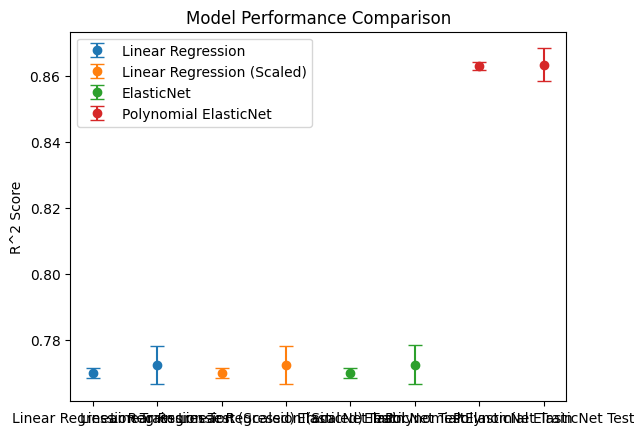

In [16]:
for model in results.keys():
    plt.errorbar([model + ' Train', model + ' Test'], 
                 [np.median([x[0] for x in results[model]]), np.median([x[1] for x in results[model]])], 
                 yerr=[np.std([x[0] for x in results[model]]), np.std([x[1] for x in results[model]])],
                 fmt='o', capsize=5, label=model)

plt.ylabel('R^2 Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

## Permutation Importance for ElasticNet model

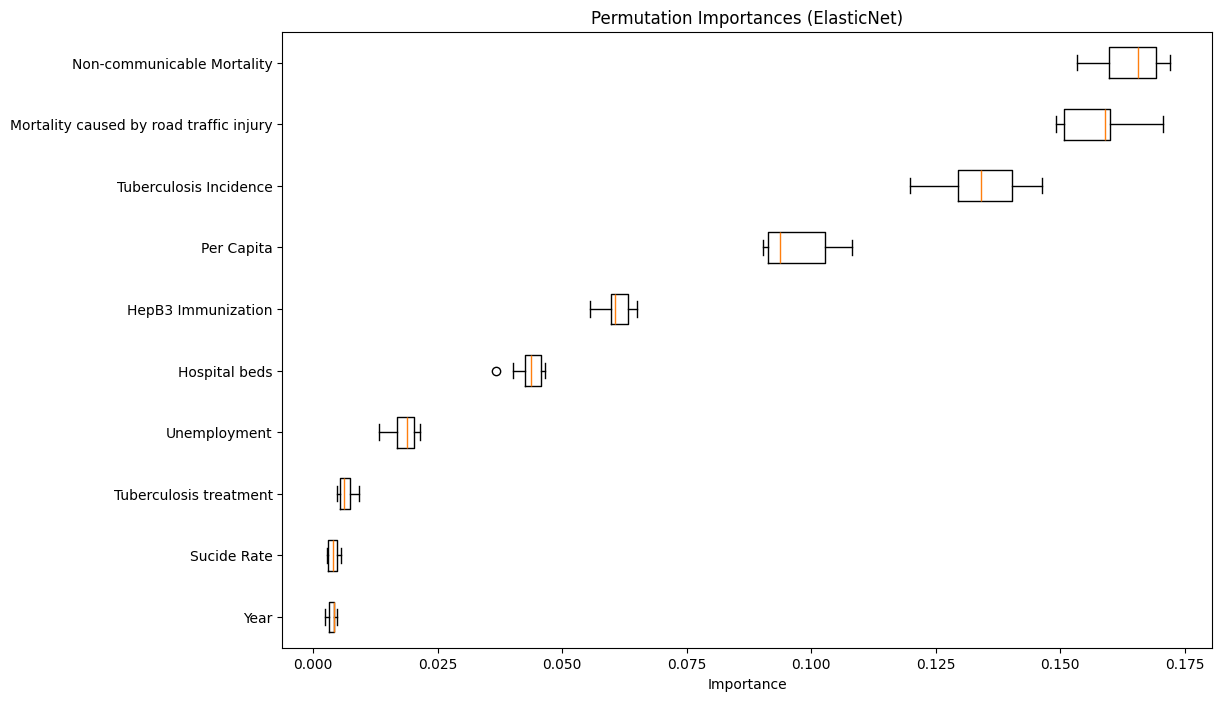

In [17]:
from sklearn.inspection import permutation_importance


elastic_net_model = models['ElasticNet'][0]  # Take the first ElasticNet model for demonstration
perm_importance = permutation_importance(elastic_net_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Get sorted feature importance indices
sorted_idx = perm_importance.importances_mean.argsort()

# Plot Permutation Importance
plt.figure(figsize=(12, 8))
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, tick_labels=np.array(X_deduped.columns)[sorted_idx])
plt.title("Permutation Importances (ElasticNet)")
plt.xlabel("Importance")
plt.show()